In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
# Merge customer and transaction data
merged_data = transactions.merge(customers, on='CustomerID', how='left')

In [4]:
# Feature Engineering
# Aggregate transaction data to create customer profiles
customer_profile = merged_data.groupby('CustomerID').agg(
    TotalSpending=('TotalValue', 'sum'),
    TransactionCount=('TransactionID', 'nunique'),
    AverageSpending=('TotalValue', 'mean')
).reset_index()

In [5]:
# Add region as a categorical feature
region_dummies = pd.get_dummies(customers[['CustomerID', 'Region']], columns=['Region'], drop_first=True)
customer_profile = customer_profile.merge(region_dummies, on='CustomerID', how='left')


In [6]:
# Normalize the features
scaler = StandardScaler()
numeric_features = customer_profile.drop(columns=['CustomerID']).columns
customer_profile[numeric_features] = scaler.fit_transform(customer_profile[numeric_features])


In [7]:
# Clustering with KMeans
# Choose the number of clusters using the elbow method
inertia = []
silhouette_scores = []
db_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_profile[numeric_features])
    labels = kmeans.labels_
    
    # Append metrics
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(customer_profile[numeric_features], labels))
    db_scores.append(davies_bouldin_score(customer_profile[numeric_features], labels))


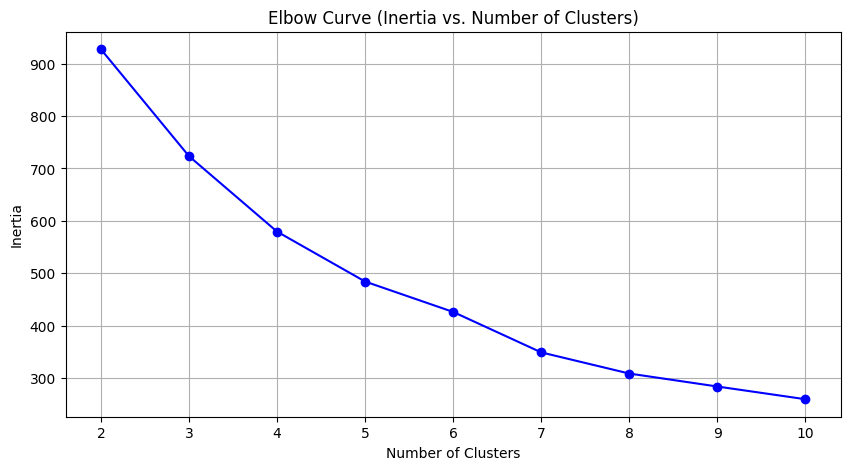

In [10]:
# Plot the elbow curve (inertia vs number of clusters)
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertia, marker='o',color='blue')
plt.title('Elbow Curve (Inertia vs. Number of Clusters)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

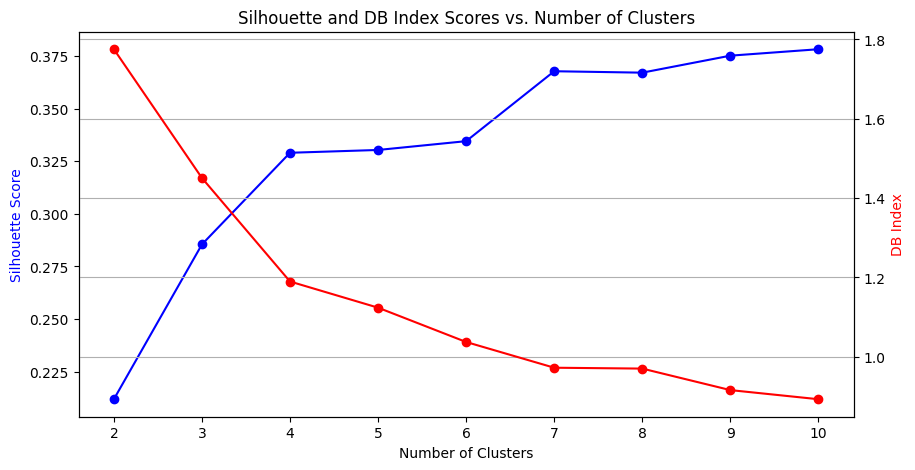

In [11]:
# Plot silhouette and DB Index scores
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette Score', color='blue')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette Score', color='blue')
ax2 = ax1.twinx()
ax2.plot(cluster_range, db_scores, marker='o', label='DB Index', color='red')
ax2.set_ylabel('DB Index', color='red')
plt.title('Silhouette and DB Index Scores vs. Number of Clusters')
plt.grid()
plt.show()

In [12]:
# Select the optimal number of clusters based on metrics
optimal_k = db_scores.index(min(db_scores)) + 2
print(f"Optimal number of clusters based on DB Index: {optimal_k}")


Optimal number of clusters based on DB Index: 10


In [13]:
# Final Clustering with optimal number of clusters
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
customer_profile['Cluster'] = kmeans_final.fit_predict(customer_profile[numeric_features])


C:\Users\sreevishak\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sreevishak\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sreevishak\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\sreevishak\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if

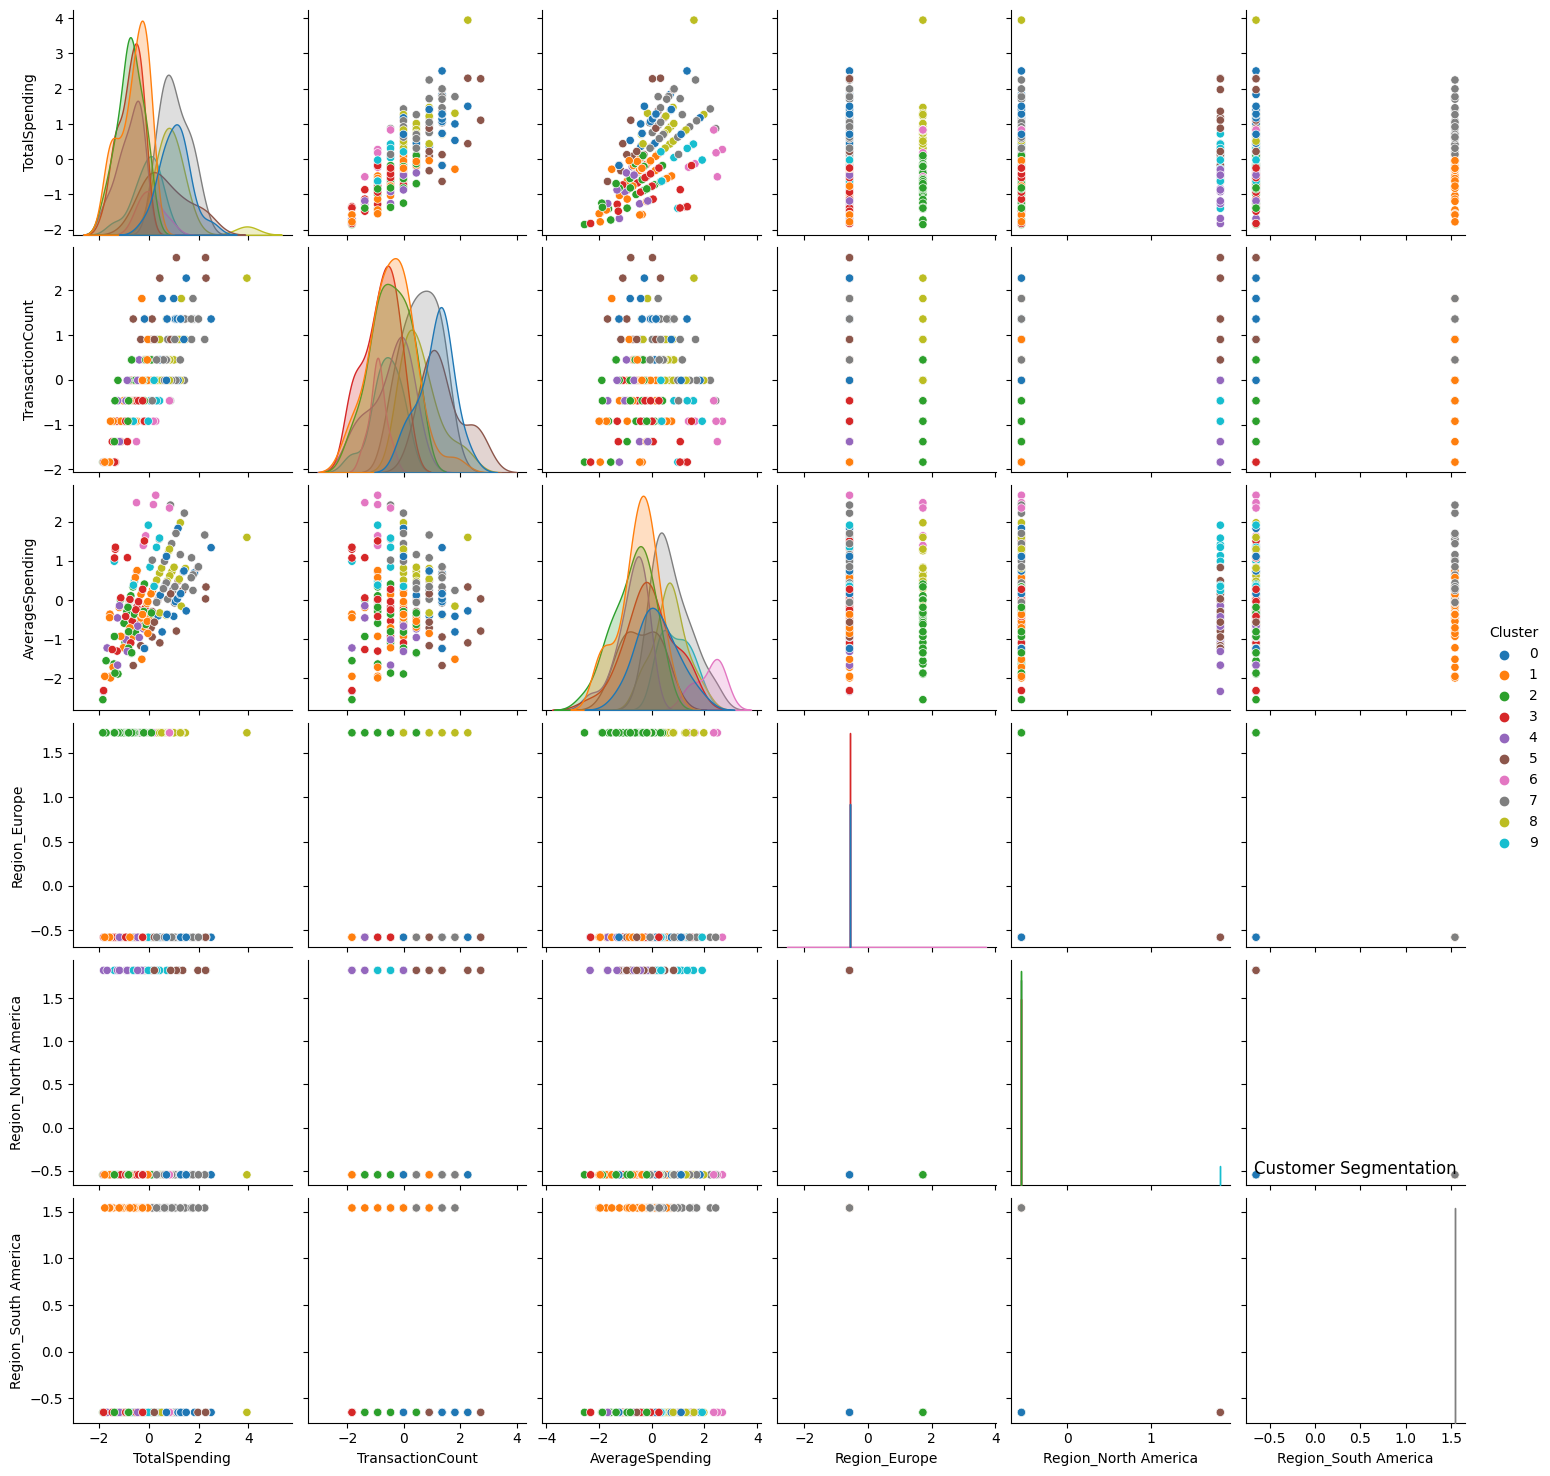

In [14]:
# Visualize the clusters
sns.pairplot(customer_profile, hue='Cluster', diag_kind='kde', palette='tab10')
plt.title('Customer Segmentation')
plt.show()


In [15]:
# Save clustering results
customer_profile.to_csv('FirstName_LastName_Clustering.csv', index=False)

# Evaluate and summarize clustering
db_index = davies_bouldin_score(customer_profile[numeric_features], customer_profile['Cluster'])
silhouette_avg = silhouette_score(customer_profile[numeric_features], customer_profile['Cluster'])

print(f"DB Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")
print(f"Number of Clusters: {optimal_k}")

DB Index: 0.8928183627160464
Silhouette Score: 0.37814926523416736
Number of Clusters: 10
